In [14]:
import os
import sys
sep = os.sep
import numpy as np
# from testarch.unet import runs as ru
from testarch.miniunet import runs as ru
import utils.auto_split as asp

In [15]:
from PIL import Image as IMG
from utils.img_utils import Image
from sklearn.metrics import precision_recall_fscore_support
from scipy.ndimage.morphology import distance_transform_edt

In [20]:
runs_unet = [
    ru.DRIVE_WEIGHTED, ru.DRIVE_1_1, ru.DRIVE_1_100_1,
    ru.STARE_WEIGHTED, ru.STARE_1_1, ru.STARE_1_100_1,
    ru.WIDE_WEIGHTED, ru.WIDE_1_1, ru.WIDE_1_100_1,
    ru.VEVIO_MOSAICS_WEIGHTED, ru.VEVIO_MOSAICS_1_1, ru.VEVIO_MOSAICS_1_100_1,
    ru.VEVIO_FRAMES_WEIGHTED, ru.VEVIO_FRAMES_1_1, ru.VEVIO_FRAMES_1_100_1]

In [21]:
log_file = 'F1'+sep+'DRIVE_MINIUNET.csv'

In [22]:
with open(log_file, 'w+') as log:
    log.write('DATASET,EXPERIMENT,PREC_AVG,RECALL_AVG,F1')
    for d in runs_unet:
        print(d['Dirs']['logs'])
        dset = d['Dirs']['logs'].split(os.sep)[1]
        exp = d['Dirs']['logs'].split(os.sep)[-1]
        results = {'p':[],'r':[], 'f1':[]}

        test_files = []
        for split_file in os.listdir(d['Dirs']['splits_json']):
            test_files += asp.load_split_json(d['Dirs']['splits_json']+sep+split_file)['test']

        for file in test_files:
            image = Image()
            image.load_file(d['Dirs']['image'], file)
            image.load_ground_truth(d['Dirs']['truth'], d['Funcs']['truth_getter'])

            if d['Dirs'].get('mask'):
                image.load_mask(d['Dirs']['mask'], d['Funcs']['mask_getter'])
            
            try:
                pred_file =  'pred_' + file.split('.')[0] + '.png'
                image.pred = np.array(IMG.open(d['Dirs']['logs'] + sep + pred_file))
            except:
                pred_file =  file.split('.')[0] + '.png'
                image.pred = np.array(IMG.open(d['Dirs']['logs'] + sep + pred_file))

            image.pred[image.pred==255] = 1

            gt = image.ground_truth.copy()
            gt[gt==255] = 1
            edt_gt = distance_transform_edt(gt)

            edt = edt_gt.copy()
            edt[edt>2] = 0
            
            ### Supress thick vessels when computing F1 Score
            gt_masked = gt.copy()
            gt_masked[edt==0] = 0
            
            pred_masked = image.pred.copy()
            pred_masked[edt==0] = 0

            p, r, f1, _ = precision_recall_fscore_support(gt.flatten(), image.pred.flatten(), average='binary')
            results['p'].append(p)
            results['r'].append(r)
            results['f1'].append(f1)
        p_avg = np.array(results['p']).mean()
        r_avg = np.array(results['r']).mean()
        f1 =  (2 * p_avg * r_avg) / (p_avg + r_avg)
        line = '{},{},{},{},{}'.format(dset, exp, round(p_avg, 5), round(r_avg, 5), round(f1, 5))
        log.write('\n'+line)
        log.flush()

logs\DRIVE\MINI_UNET_WEIGHTED
### SPLIT FOUND:  data\DRIVE\splits\DRIVE.json Loaded
logs\DRIVE\MINI_UNET_1__1
### SPLIT FOUND:  data\DRIVE\splits\DRIVE.json Loaded
logs\DRIVE\MINI_UNET_1_100_1
### SPLIT FOUND:  data\DRIVE\splits\DRIVE.json Loaded
logs\STARE\MINI_UNET_WEIGHTED
### SPLIT FOUND:  data\STARE\splits\STARE_0.json Loaded
### SPLIT FOUND:  data\STARE\splits\STARE_1.json Loaded
### SPLIT FOUND:  data\STARE\splits\STARE_2.json Loaded
### SPLIT FOUND:  data\STARE\splits\STARE_3.json Loaded
### SPLIT FOUND:  data\STARE\splits\STARE_4.json Loaded
logs\STARE\MINI_UNET_1__1
### SPLIT FOUND:  data\STARE\splits\STARE_0.json Loaded
### SPLIT FOUND:  data\STARE\splits\STARE_1.json Loaded
### SPLIT FOUND:  data\STARE\splits\STARE_2.json Loaded
### SPLIT FOUND:  data\STARE\splits\STARE_3.json Loaded
### SPLIT FOUND:  data\STARE\splits\STARE_4.json Loaded
logs\STARE\MINI_UNET_1_100_1
### SPLIT FOUND:  data\STARE\splits\STARE_0.json Loaded
### SPLIT FOUND:  data\STARE\splits\STARE_1.json Loa

In [5]:
import json

In [29]:
def create_splits(files, k=0, json_file='SPLIT', shuffle_files=True):
    import json
    from random import shuffle
    from itertools import chain
    
    json_file = json_file.split('.')[0] + '.json'
    if shuffle_files:
        shuffle(files)
        
    ix_splits =  np.array_split(np.arange(len(files)), k)
    for i in range(len(ix_splits)):
        
        test_ix = ix_splits[i].tolist()
        val_ix = ix_splits[(i+1)%len(ix_splits)].tolist()
        train_ix = [ix for ix in np.arange(len(files)) if ix not in test_ix + val_ix]
        
        splits = {}
        splits['train'] = [files[ix] for ix in train_ix]
        splits['validation'] = [files[ix] for ix in val_ix]
        splits['test'] = [files[ix] for ix in test_ix]
        
        print('Valid:', set(list(chain(*splits.values())))- set(files)==set([]))
        
        f = open(str(i) + json_file, "w")
        f.write(json.dumps(splits))
        f.close()

In [31]:
create_splits(os.listdir(ru.DRIVE_1_100_1['Dirs']['image']), k=5, json_file='CHASEDB')

Valid: True
Valid: True
Valid: True
Valid: True
Valid: True


In [103]:
import torch

In [102]:
def dice_loss(outputs=None, target=None, beta=1, weights=None,):
    """
    :param weights: element-wise weights
    :param outputs:
    :param target:
    :param beta: More beta, better precision. 1 is neutral
    :return:
    """
    smooth = 1.
    if weights is not None:
        weights = weights.contiguous().float().view(-1)
    else:
        weights = 1

    iflat = outputs.contiguous().float().view(-1)
    tflat = target.contiguous().float().view(-1)
    intersection = (iflat * tflat * weights).sum()

    f = (((1 + beta ** 2) * intersection) + smooth) / (((beta ** 2 * iflat.sum()) + tflat.sum()) + smooth)
    return 1 - f


In [190]:
a = torch.Tensor([1, 1, 0, 1, 0])
b = torch.Tensor([1, 0, 1, 1, 1])

In [204]:
dice_loss(a, b, 1)

tensor(0.3750)

In [192]:
y_true = b.clone().int().view(1, -1).squeeze()
y_pred = a.clone().int().view(1, -1).squeeze()

y_true[y_true == 255] = 1
y_pred[y_pred == 255] = 1

y_true = y_true * 2
y_cases = y_true + y_pred
tp = torch.sum(y_cases == 3).item()
fp = torch.sum(y_cases == 1).item()
tn = torch.sum(y_cases == 0).item()
fn = torch.sum(y_cases == 2).item()

In [209]:
beta  = 0
try:
    p = tp / (tp + fp)
except ZeroDivisionError:
    p = 0
try:
    r = tp / (tp + fn)
except ZeroDivisionError:
    r = 0
try:
    f = (1 + beta ** 2) * p * r / (((beta ** 2) * p) + r)
except ZeroDivisionError:
    f = 0

In [212]:
import random
# Lets define our Beta Function to generate s for any particular state. We don't care for the normalizing constant here.
def beta_s(w,a,b):
    return w**(a-1)*(1-w)**(b-1)

# This Function returns True if the coin with probability P of heads comes heads when flipped.
def random_coin(p):
    unif = random.uniform(0,1)
    if unif>=p:
        return False
    else:
        return True

# This Function runs the MCMC chain for Beta Distribution.
def beta_mcmc(N_hops,a,b):
    states = []
    cur = random.uniform(0,1)
    for i in range(0,N_hops):
        states.append(cur)
        next = random.uniform(0,1)
        ap = min(beta_s(next,a,b)/beta_s(cur,a,b),1) # Calculate the acceptance probability
        if random_coin(ap):
            cur = next
    return states[-1000:] # Returns the last 100 states of the chain

c:\python37\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
c:\python37\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]
c:\python37\lib\site-packages\ipykernel_launcher.py:25: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


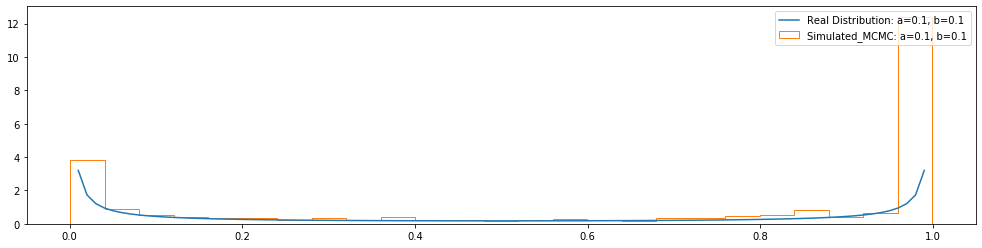

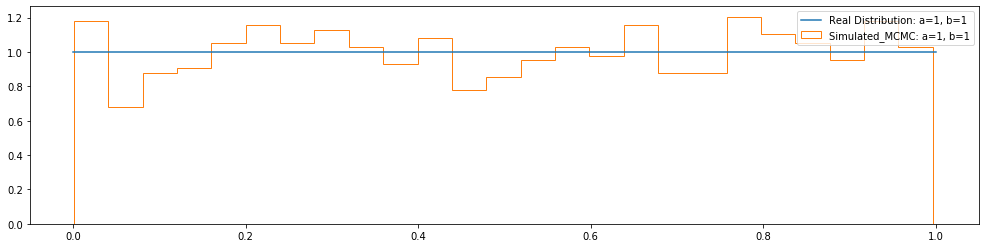

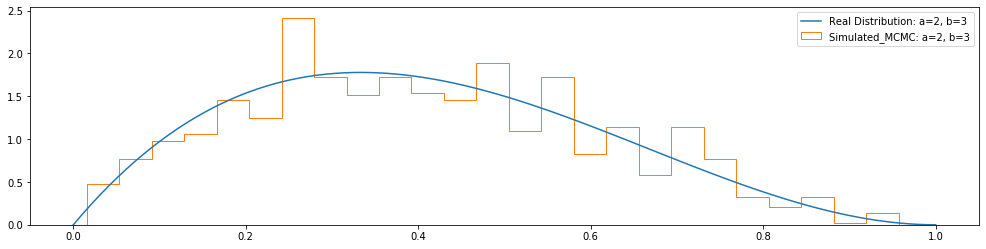

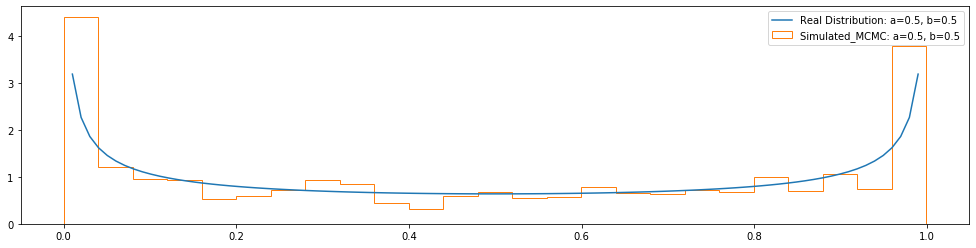

In [214]:
import numpy as np
import pylab as pl
import scipy.special as ss
%matplotlib inline
pl.rcParams['figure.figsize'] = (17.0, 4.0)

# Actual Beta PDF.
def beta(a, b, i):
    e1 = ss.gamma(a + b)
    e2 = ss.gamma(a)
    e3 = ss.gamma(b)
    e4 = i ** (a - 1)
    e5 = (1 - i) ** (b - 1)
    return (e1/(e2*e3)) * e4 * e5

# Create a function to plot Actual Beta PDF with the Beta Sampled from MCMC Chain.
def plot_beta(a, b):
    Ly = []
    Lx = []
    i_list = np.mgrid[0:1:100j]
    for i in i_list:
        Lx.append(i)
        Ly.append(beta(a, b, i))
    pl.plot(Lx, Ly, label="Real Distribution: a="+str(a)+", b="+str(b))
    pl.hist(beta_mcmc(100000,a,b),normed=True,bins =25, histtype='step',label="Simulated_MCMC: a="+str(a)+", b="+str(b))
    pl.legend()
    pl.show()
    
plot_beta(0.1, 0.1)
plot_beta(1, 1)
plot_beta(2, 3)
plot_beta(0.5, 0.5)

In [197]:
p, r, f

(0.6666666666666666, 0.5, 0.5048543689320388)

In [246]:
a = 1==1 5 else 10

SyntaxError: invalid syntax (<ipython-input-246-b4e289aa5450>, line 1)